# Setup
## Constants

In [13]:
!pip install transformers -q
!pip install torch -q
!pip install torchvision -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = True

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 400

# path to dataset (do not change)
HM_DATA_PATH = "../dataset/"

# path to pth saves (do not change)
PTH_SAVE_PATH = "../pth/"

## Imports

In [15]:
import os, sys, random, importlib, transformers, itertools, copy
import numpy as np, torch.nn as nn, torch, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
print(os.getcwd())# Our own files
# sys.path.append('./src/')
import model_functions, utils, training, datasets
def set_seed(seed):# reproducable
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(0)

/Users/daghjelm/Documents/kth/ds-proj/DD2430_Project/src


In [16]:
def update():# if you change our files
    import model_functions, utils, training, datasets
    for lib in [model_functions, utils, training, datasets]:
        importlib.reload(lib)# issues with not updating
update()

In [17]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available(): # For apple silicon
    device = 'mps'
print("Using device:", device)

Using device: mps


In [18]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/opt/homebrew/Caskroom/miniconda/base/envs/ds-proj/lib/python3.12/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [19]:
print(type(processor))

<class 'transformers.models.clip.processing_clip.CLIPProcessor'>


### Load dataset and split

## Create new imbalanced dataset

Main class for dataset

In [20]:
main_class = 'garment_group_name'

### Full dataset, run once

In [21]:
df = pd.read_csv(HM_DATA_PATH+'articles_filtered.csv')
embs = torch.load(HM_DATA_PATH+'embedds.pth', weights_only=True) # all 100k embeddings
labs = torch.load(HM_DATA_PATH+'labels.pth', weights_only=True).tolist() #  100k labels
hmd = datasets.HMDatasetDuplicates(embs, np.array(labs), df)
print(hmd.article_id2suclass(694805002, main_class))
#print(hmd.list_article_id2suclass(labs, 'garment_group_name'))#all
print(len(labs))
BALANCED = False

Knitwear
105099


In [22]:
print(type(processor.tokenizer))

<class 'transformers.models.clip.tokenization_clip_fast.CLIPTokenizerFast'>


In [23]:
update()
batch_size = 32
set_sizes = {"train": 0.8, "val": 0.1}
data = datasets.datasets(embs, np.array(labs), df, set_sizes, True)# takes 3 min

KeyboardInterrupt: 

### Subsets

In [24]:
update()
exclude_classes = ['Special Offers', 'Woven/Jersey/Knitted mix Baby','Unknown']
dataloaders_imbalanced = datasets.get_dataloaders('garment_group_name', data, 500, exclude_classes, 32)# look at Resource Utilization to see if capping

 54%|█████▍    | 45309/84095 [00:09<00:08, 4758.68it/s]


KeyboardInterrupt: 

In [11]:
dataloaders = dataloaders_imbalanced

## Add description to labels



  0%|          | 0/133 [00:00<?, ?it/s]

texts ['An image of clothing with name: Dresses Ladies, and description: Cardigan in a soft fine knit with dropped shoulders, long sleeves, a visible seam at the back and no buttons.', 'An image of clothing with name: Under-, Nightwear, and description: Cardigan in a soft fine knit with dropped shoulders, long sleeves, a visible seam at the back and no buttons.', 'An image of clothing with name: Outdoor, and description: Cardigan in a soft fine knit with dropped shoulders, long sleeves, a visible seam at the back and no buttons.', 'An image of clothing with name: Shirts, and description: Cardigan in a soft fine knit with dropped shoulders, long sleeves, a visible seam at the back and no buttons.', 'An image of clothing with name: Dresses/Skirts girls, and description: Cardigan in a soft fine knit with dropped shoulders, long sleeves, a visible seam at the back and no buttons.', 'An image of clothing with name: Blouses, and description: Cardigan in a soft fine knit with dropped shoulder

  1%|          | 1/133 [00:06<13:40,  6.22s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Small shoulder bag in cotton twill covered in plastic beads with a zip at the top, detachable metal chain shoulder strap and a zipped inner compartment. Cotton twill lining. Height 14 cm. Width 20 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Small shoulder bag in cotton twill covered in plastic beads with a zip at the top, detachable metal chain shoulder strap and a zipped inner compartment. Cotton twill lining. Height 14 cm. Width 20 cm.', 'An image of clothing with name: Outdoor, and description: Small shoulder bag in cotton twill covered in plastic beads with a zip at the top, detachable metal chain shoulder strap and a zipped inner compartment. Cotton twill lining. Height 14 cm. Width 20 cm.', 'An image of clothing with name: Shirts, and description: Small shoulder bag in cotton twill covered in plastic beads with a zip at the top, detachable metal chain shoulder strap and a zippe

  2%|▏         | 2/133 [00:11<11:58,  5.48s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Outdoor, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Shirts, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Blouses, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Jersey Fancy, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.', 'An image of clothing with name: Knitwear, and description: Acetate earrings with rectangular pendants. Length 4.6 cm.'

  2%|▏         | 3/133 [00:15<10:49,  5.00s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Smartphone bag in soft, transparent plastic with an adjustable shoulder strap, zip at the top and a zipped outer compartment. Depth 5 cm. Width 10.5 cm. Height 15 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Smartphone bag in soft, transparent plastic with an adjustable shoulder strap, zip at the top and a zipped outer compartment. Depth 5 cm. Width 10.5 cm. Height 15 cm.', 'An image of clothing with name: Outdoor, and description: Smartphone bag in soft, transparent plastic with an adjustable shoulder strap, zip at the top and a zipped outer compartment. Depth 5 cm. Width 10.5 cm. Height 15 cm.', 'An image of clothing with name: Shirts, and description: Smartphone bag in soft, transparent plastic with an adjustable shoulder strap, zip at the top and a zipped outer compartment. Depth 5 cm. Width 10.5 cm. Height 15 cm.', 'An image of clothing with name: Dresses/Skirts girls, and descri

  3%|▎         | 4/133 [00:19<10:00,  4.65s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: T-shirts in soft, printed cotton jersey with press-studs on one shoulder and slits in the sides. Slightly longer at the back.', 'An image of clothing with name: Under-, Nightwear, and description: T-shirts in soft, printed cotton jersey with press-studs on one shoulder and slits in the sides. Slightly longer at the back.', 'An image of clothing with name: Outdoor, and description: T-shirts in soft, printed cotton jersey with press-studs on one shoulder and slits in the sides. Slightly longer at the back.', 'An image of clothing with name: Shirts, and description: T-shirts in soft, printed cotton jersey with press-studs on one shoulder and slits in the sides. Slightly longer at the back.', 'An image of clothing with name: Dresses/Skirts girls, and description: T-shirts in soft, printed cotton jersey with press-studs on one shoulder and slits in the sides. Slightly longer at the back.', 'An image of clothing with na

  4%|▍         | 5/133 [00:23<09:11,  4.31s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Imitation leather shopper with imitation suede inside, two handles and a magnetic fastener at the top. One inner compartment with an additional zipped pocket. Unlined. Size approx. 13x33x41 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Imitation leather shopper with imitation suede inside, two handles and a magnetic fastener at the top. One inner compartment with an additional zipped pocket. Unlined. Size approx. 13x33x41 cm.', 'An image of clothing with name: Outdoor, and description: Imitation leather shopper with imitation suede inside, two handles and a magnetic fastener at the top. One inner compartment with an additional zipped pocket. Unlined. Size approx. 13x33x41 cm.', 'An image of clothing with name: Shirts, and description: Imitation leather shopper with imitation suede inside, two handles and a magnetic fastener at the top. One inner compartment with an additional zipped po

  5%|▍         | 6/133 [00:27<08:49,  4.17s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Under-, Nightwear, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Outdoor, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Shirts, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Dresses/Skirts girls, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Blouses, and description: Print-patterned swim shorts with an elasticated drawstring waist. Soft mesh inner shorts.', 'An image of clothing with name: Jersey Fancy, and descrip

  5%|▌         | 7/133 [00:31<08:36,  4.10s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: 5-pocket, knee-length shorts in washed, stretch denim with an adjustable elasticated waist (in sizes 8-12Y) and zip fly and button.', 'An image of clothing with name: Under-, Nightwear, and description: 5-pocket, knee-length shorts in washed, stretch denim with an adjustable elasticated waist (in sizes 8-12Y) and zip fly and button.', 'An image of clothing with name: Outdoor, and description: 5-pocket, knee-length shorts in washed, stretch denim with an adjustable elasticated waist (in sizes 8-12Y) and zip fly and button.', 'An image of clothing with name: Shirts, and description: 5-pocket, knee-length shorts in washed, stretch denim with an adjustable elasticated waist (in sizes 8-12Y) and zip fly and button.', 'An image of clothing with name: Dresses/Skirts girls, and description: 5-pocket, knee-length shorts in washed, stretch denim with an adjustable elasticated waist (in sizes 8-12Y) and zip fly and button.',

  6%|▌         | 8/133 [00:34<08:14,  3.96s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Soft toy in soft faux fur with embroidery and shimmering details and appliqués. Glittery detachable wings in felt and a removable satin dress that has a skirt with a layer of patterned tulle. Size approx. 21x32 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Soft toy in soft faux fur with embroidery and shimmering details and appliqués. Glittery detachable wings in felt and a removable satin dress that has a skirt with a layer of patterned tulle. Size approx. 21x32 cm.', 'An image of clothing with name: Outdoor, and description: Soft toy in soft faux fur with embroidery and shimmering details and appliqués. Glittery detachable wings in felt and a removable satin dress that has a skirt with a layer of patterned tulle. Size approx. 21x32 cm.', 'An image of clothing with name: Shirts, and description: Soft toy in soft faux fur with embroidery and shimmering details and appliqués. Glittery d

  7%|▋         | 9/133 [00:38<08:03,  3.90s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length balloon sleeves and elasticated cuffs. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length balloon sleeves and elasticated cuffs. Unlined.', 'An image of clothing with name: Outdoor, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length balloon sleeves and elasticated cuffs. Unlined.', 'An image of clothing with name: Shirts, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length balloon sleeves and elasticated cuffs. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length balloon sleeves and elasticated cuffs. Unlined.', 'An image of clothing with name: Blouses, and description: Straight-cut V-neck dress in a cotton weave with 3/4-length 

  8%|▊         | 10/133 [00:42<07:49,  3.81s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Ankle-length sports tights in fast-drying functional fabric. Extra-high waist with a wide waist panel and raw-edge hems.', 'An image of clothing with name: Under-, Nightwear, and description: Ankle-length sports tights in fast-drying functional fabric. Extra-high waist with a wide waist panel and raw-edge hems.', 'An image of clothing with name: Outdoor, and description: Ankle-length sports tights in fast-drying functional fabric. Extra-high waist with a wide waist panel and raw-edge hems.', 'An image of clothing with name: Shirts, and description: Ankle-length sports tights in fast-drying functional fabric. Extra-high waist with a wide waist panel and raw-edge hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Ankle-length sports tights in fast-drying functional fabric. Extra-high waist with a wide waist panel and raw-edge hems.', 'An image of clothing with name: Blouses, and descript

  8%|▊         | 11/133 [00:45<07:38,  3.75s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short V-neck dress in jersey crêpe with a narrow, detachable tie belt at the waist and 3/4-length sleeves with cuffs and decorative buttons. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Short V-neck dress in jersey crêpe with a narrow, detachable tie belt at the waist and 3/4-length sleeves with cuffs and decorative buttons. Unlined.', 'An image of clothing with name: Outdoor, and description: Short V-neck dress in jersey crêpe with a narrow, detachable tie belt at the waist and 3/4-length sleeves with cuffs and decorative buttons. Unlined.', 'An image of clothing with name: Shirts, and description: Short V-neck dress in jersey crêpe with a narrow, detachable tie belt at the waist and 3/4-length sleeves with cuffs and decorative buttons. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short V-neck dress in jersey crêpe with a narrow, detachable 

  9%|▉         | 12/133 [00:49<07:28,  3.71s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Straight-cut jacket in woven fabric with notch lapels and patch front pockets. One-button fastening at the front, decorative buttons at the cuffs and a single back vent. Lined. The polyester content of the jacket is partly recycled.', 'An image of clothing with name: Under-, Nightwear, and description: Straight-cut jacket in woven fabric with notch lapels and patch front pockets. One-button fastening at the front, decorative buttons at the cuffs and a single back vent. Lined. The polyester content of the jacket is partly recycled.', 'An image of clothing with name: Outdoor, and description: Straight-cut jacket in woven fabric with notch lapels and patch front pockets. One-button fastening at the front, decorative buttons at the cuffs and a single back vent. Lined. The polyester content of the jacket is partly recycled.', 'An image of clothing with name: Shirts, and description: Straight-cut jacket in woven fabric 

 10%|▉         | 13/133 [00:53<07:20,  3.67s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Under-, Nightwear, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Outdoor, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Shirts, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Dresses/Skirts girls, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Blouses, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Jersey Fancy, and description: Headband in a soft knit with a knot detail at the front.', 'An image of clothing with name: Knitwear, and description: Headband in a soft knit with a knot detail at the front.', 'An image of c

 11%|█         | 14/133 [00:57<07:25,  3.74s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short skirt in a crêpe weave with a high paper bag waist, detachable tie belt, pleats at the top and buttons down the front. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Short skirt in a crêpe weave with a high paper bag waist, detachable tie belt, pleats at the top and buttons down the front. Lined.', 'An image of clothing with name: Outdoor, and description: Short skirt in a crêpe weave with a high paper bag waist, detachable tie belt, pleats at the top and buttons down the front. Lined.', 'An image of clothing with name: Shirts, and description: Short skirt in a crêpe weave with a high paper bag waist, detachable tie belt, pleats at the top and buttons down the front. Lined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short skirt in a crêpe weave with a high paper bag waist, detachable tie belt, pleats at the top and buttons down the front. Lined.',

 11%|█▏        | 15/133 [01:00<07:24,  3.76s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Straight-cut top in a softly draping weave with a concealed zip at the back, dropped shoulders and short sleeves in a double layer of flounces.', 'An image of clothing with name: Under-, Nightwear, and description: Straight-cut top in a softly draping weave with a concealed zip at the back, dropped shoulders and short sleeves in a double layer of flounces.', 'An image of clothing with name: Outdoor, and description: Straight-cut top in a softly draping weave with a concealed zip at the back, dropped shoulders and short sleeves in a double layer of flounces.', 'An image of clothing with name: Shirts, and description: Straight-cut top in a softly draping weave with a concealed zip at the back, dropped shoulders and short sleeves in a double layer of flounces.', 'An image of clothing with name: Dresses/Skirts girls, and description: Straight-cut top in a softly draping weave with a concealed zip at the back, dropped 

 12%|█▏        | 16/133 [01:04<07:19,  3.76s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Calf-length dress in an airy, patterned linen and viscose weave with wide, adjustable shoulder straps that can be fastened in different ways at the back. Gathered seam at the waist, a concealed zip in one side and a softly draping, flared skirt. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Calf-length dress in an airy, patterned linen and viscose weave with wide, adjustable shoulder straps that can be fastened in different ways at the back. Gathered seam at the waist, a concealed zip in one side and a softly draping, flared skirt. Unlined.', 'An image of clothing with name: Outdoor, and description: Calf-length dress in an airy, patterned linen and viscose weave with wide, adjustable shoulder straps that can be fastened in different ways at the back. Gathered seam at the waist, a concealed zip in one side and a softly draping, flared skirt. Unlined.', 'An image of clothing with n

 13%|█▎        | 17/133 [01:08<07:08,  3.69s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Knee-length shorts in sturdy cotton twill with napped details. Button fly, side pockets, back pockets, a coin pocket and frayed, raw-edge hems.', 'An image of clothing with name: Under-, Nightwear, and description: Knee-length shorts in sturdy cotton twill with napped details. Button fly, side pockets, back pockets, a coin pocket and frayed, raw-edge hems.', 'An image of clothing with name: Outdoor, and description: Knee-length shorts in sturdy cotton twill with napped details. Button fly, side pockets, back pockets, a coin pocket and frayed, raw-edge hems.', 'An image of clothing with name: Shirts, and description: Knee-length shorts in sturdy cotton twill with napped details. Button fly, side pockets, back pockets, a coin pocket and frayed, raw-edge hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Knee-length shorts in sturdy cotton twill with napped details. Button fly, side pocke

 14%|█▎        | 18/133 [01:11<06:59,  3.65s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Trousers in a sturdy weave with a regular waist that is elasticated at the back, concealed hook-and-eye fasteners and a zip fly. Side pockets, a welt back pocket and tapered legs with contrasting colour stripes down the sides.', 'An image of clothing with name: Under-, Nightwear, and description: Trousers in a sturdy weave with a regular waist that is elasticated at the back, concealed hook-and-eye fasteners and a zip fly. Side pockets, a welt back pocket and tapered legs with contrasting colour stripes down the sides.', 'An image of clothing with name: Outdoor, and description: Trousers in a sturdy weave with a regular waist that is elasticated at the back, concealed hook-and-eye fasteners and a zip fly. Side pockets, a welt back pocket and tapered legs with contrasting colour stripes down the sides.', 'An image of clothing with name: Shirts, and description: Trousers in a sturdy weave with a regular waist that i

 14%|█▍        | 19/133 [01:15<07:05,  3.73s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Soft, non-wired nursing bra in organic cotton jersey with adjustable shoulder straps and padded, opening cups with space for nursing pads. Hook-and-eye fastening at the back and a lace trim at the hem. The cups are lined with fabric made from recycled polyester.', 'An image of clothing with name: Under-, Nightwear, and description: Soft, non-wired nursing bra in organic cotton jersey with adjustable shoulder straps and padded, opening cups with space for nursing pads. Hook-and-eye fastening at the back and a lace trim at the hem. The cups are lined with fabric made from recycled polyester.', 'An image of clothing with name: Outdoor, and description: Soft, non-wired nursing bra in organic cotton jersey with adjustable shoulder straps and padded, opening cups with space for nursing pads. Hook-and-eye fastening at the back and a lace trim at the hem. The cups are lined with fabric made from recycled polyester.', 'An 

 15%|█▌        | 20/133 [01:19<07:03,  3.75s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Wrapover pointelle bodysuits in soft organic cotton jersey with long sleeves and press-studs at the side and crotch.', 'An image of clothing with name: Under-, Nightwear, and description: Wrapover pointelle bodysuits in soft organic cotton jersey with long sleeves and press-studs at the side and crotch.', 'An image of clothing with name: Outdoor, and description: Wrapover pointelle bodysuits in soft organic cotton jersey with long sleeves and press-studs at the side and crotch.', 'An image of clothing with name: Shirts, and description: Wrapover pointelle bodysuits in soft organic cotton jersey with long sleeves and press-studs at the side and crotch.', 'An image of clothing with name: Dresses/Skirts girls, and description: Wrapover pointelle bodysuits in soft organic cotton jersey with long sleeves and press-studs at the side and crotch.', 'An image of clothing with name: Blouses, and description: Wrapover pointe

 16%|█▌        | 21/133 [01:23<07:07,  3.81s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Biker jacket in soft imitation leather with quilted details. Collar with a detachable faux fur layer on top, and press-studs on the lapels. Diagonal zip down the front, zipped side pockets and long sleeves with a zip at the cuffs. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Biker jacket in soft imitation leather with quilted details. Collar with a detachable faux fur layer on top, and press-studs on the lapels. Diagonal zip down the front, zipped side pockets and long sleeves with a zip at the cuffs. Lined.', 'An image of clothing with name: Outdoor, and description: Biker jacket in soft imitation leather with quilted details. Collar with a detachable faux fur layer on top, and press-studs on the lapels. Diagonal zip down the front, zipped side pockets and long sleeves with a zip at the cuffs. Lined.', 'An image of clothing with name: Shirts, and description: Biker jacket in soft 

 17%|█▋        | 22/133 [01:27<07:11,  3.88s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Padded gilet in woven fabric with an imitation leather yoke. Detachable, lined hood with a faux fur trim, stand-up collar, zip down the front with a chin guard, and front pockets with a press-stud. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Padded gilet in woven fabric with an imitation leather yoke. Detachable, lined hood with a faux fur trim, stand-up collar, zip down the front with a chin guard, and front pockets with a press-stud. Lined.', 'An image of clothing with name: Outdoor, and description: Padded gilet in woven fabric with an imitation leather yoke. Detachable, lined hood with a faux fur trim, stand-up collar, zip down the front with a chin guard, and front pockets with a press-stud. Lined.', 'An image of clothing with name: Shirts, and description: Padded gilet in woven fabric with an imitation leather yoke. Detachable, lined hood with a faux fur trim, stand-up colla

 17%|█▋        | 23/133 [01:31<07:14,  3.95s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fully lined sports bra in fast-drying functional fabric with a racer back and moulded, padded cups that lift and shape while providing good support. Elasticated hem and a fastening at the back with two pairs of hooks and eyes. Medium support.', 'An image of clothing with name: Under-, Nightwear, and description: Fully lined sports bra in fast-drying functional fabric with a racer back and moulded, padded cups that lift and shape while providing good support. Elasticated hem and a fastening at the back with two pairs of hooks and eyes. Medium support.', 'An image of clothing with name: Outdoor, and description: Fully lined sports bra in fast-drying functional fabric with a racer back and moulded, padded cups that lift and shape while providing good support. Elasticated hem and a fastening at the back with two pairs of hooks and eyes. Medium support.', 'An image of clothing with name: Shirts, and description: Fully 

 18%|█▊        | 24/133 [01:35<07:02,  3.88s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Bell-shaped skirt in soft cotton corduroy with covered elastication and a small frill trim at the waist and a gathered seam at the hem. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Bell-shaped skirt in soft cotton corduroy with covered elastication and a small frill trim at the waist and a gathered seam at the hem. Unlined.', 'An image of clothing with name: Outdoor, and description: Bell-shaped skirt in soft cotton corduroy with covered elastication and a small frill trim at the waist and a gathered seam at the hem. Unlined.', 'An image of clothing with name: Shirts, and description: Bell-shaped skirt in soft cotton corduroy with covered elastication and a small frill trim at the waist and a gathered seam at the hem. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Bell-shaped skirt in soft cotton corduroy with covered elastication and a small f

 19%|█▉        | 25/133 [01:38<06:47,  3.77s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Dungaree dress in cotton twill with adjustable straps with metal fasteners, buttons down the front and at the sides and front pockets.', 'An image of clothing with name: Under-, Nightwear, and description: Dungaree dress in cotton twill with adjustable straps with metal fasteners, buttons down the front and at the sides and front pockets.', 'An image of clothing with name: Outdoor, and description: Dungaree dress in cotton twill with adjustable straps with metal fasteners, buttons down the front and at the sides and front pockets.', 'An image of clothing with name: Shirts, and description: Dungaree dress in cotton twill with adjustable straps with metal fasteners, buttons down the front and at the sides and front pockets.', 'An image of clothing with name: Dresses/Skirts girls, and description: Dungaree dress in cotton twill with adjustable straps with metal fasteners, buttons down the front and at the sides and f

 20%|█▉        | 26/133 [01:42<06:42,  3.76s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Small bag in embossed suede with a metal chain shoulder strap and flap with a magnetic fastener. Lined. Size 8x11x14 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Small bag in embossed suede with a metal chain shoulder strap and flap with a magnetic fastener. Lined. Size 8x11x14 cm.', 'An image of clothing with name: Outdoor, and description: Small bag in embossed suede with a metal chain shoulder strap and flap with a magnetic fastener. Lined. Size 8x11x14 cm.', 'An image of clothing with name: Shirts, and description: Small bag in embossed suede with a metal chain shoulder strap and flap with a magnetic fastener. Lined. Size 8x11x14 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Small bag in embossed suede with a metal chain shoulder strap and flap with a magnetic fastener. Lined. Size 8x11x14 cm.', 'An image of clothing with name: Blouses, and descript

 20%|██        | 27/133 [01:46<06:43,  3.81s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Set with a vest top and shorts in soft cotton jersey. Vest top with a decorative knot detail on each shoulder strap and a print motif. Shorts with side pockets and covered elastication at the waist.', 'An image of clothing with name: Under-, Nightwear, and description: Set with a vest top and shorts in soft cotton jersey. Vest top with a decorative knot detail on each shoulder strap and a print motif. Shorts with side pockets and covered elastication at the waist.', 'An image of clothing with name: Outdoor, and description: Set with a vest top and shorts in soft cotton jersey. Vest top with a decorative knot detail on each shoulder strap and a print motif. Shorts with side pockets and covered elastication at the waist.', 'An image of clothing with name: Shirts, and description: Set with a vest top and shorts in soft cotton jersey. Vest top with a decorative knot detail on each shoulder strap and a print motif. Sho

 21%|██        | 28/133 [01:50<06:46,  3.87s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Set with an Alice band and tail in faux fur. Alice band with appliqués in the shape of ears on top. Padded tail with ribbons and a hook and loop fastening. Length of tail approx. 35 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Set with an Alice band and tail in faux fur. Alice band with appliqués in the shape of ears on top. Padded tail with ribbons and a hook and loop fastening. Length of tail approx. 35 cm.', 'An image of clothing with name: Outdoor, and description: Set with an Alice band and tail in faux fur. Alice band with appliqués in the shape of ears on top. Padded tail with ribbons and a hook and loop fastening. Length of tail approx. 35 cm.', 'An image of clothing with name: Shirts, and description: Set with an Alice band and tail in faux fur. Alice band with appliqués in the shape of ears on top. Padded tail with ribbons and a hook and loop fastening. Length of tail approx

 22%|██▏       | 29/133 [01:54<06:48,  3.92s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short, sleeveless romper suit in soft, patterned organic slub cotton jersey with buttons down the front and concealed press-studs at the crotch.', 'An image of clothing with name: Under-, Nightwear, and description: Short, sleeveless romper suit in soft, patterned organic slub cotton jersey with buttons down the front and concealed press-studs at the crotch.', 'An image of clothing with name: Outdoor, and description: Short, sleeveless romper suit in soft, patterned organic slub cotton jersey with buttons down the front and concealed press-studs at the crotch.', 'An image of clothing with name: Shirts, and description: Short, sleeveless romper suit in soft, patterned organic slub cotton jersey with buttons down the front and concealed press-studs at the crotch.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short, sleeveless romper suit in soft, patterned organic slub cotton jersey with 

 23%|██▎       | 30/133 [01:58<06:41,  3.89s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Under-, Nightwear, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Outdoor, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Shirts, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Blouses, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Jersey Fancy, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Knitwear, and description: Short-sleeved top in printed cotton jersey.', 'An image of clothing with name: Shoes, and description: Short-sleeved top in printed cotton jersey.', 'An image of cl

 23%|██▎       | 31/133 [02:02<06:35,  3.88s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Shorter jacket in washed denim with metal buttons, a collar and buttons down the front and at the cuffs. Flap chest pockets with a button, welt side pockets and an adjustable tab and button at the back.', 'An image of clothing with name: Under-, Nightwear, and description: Shorter jacket in washed denim with metal buttons, a collar and buttons down the front and at the cuffs. Flap chest pockets with a button, welt side pockets and an adjustable tab and button at the back.', 'An image of clothing with name: Outdoor, and description: Shorter jacket in washed denim with metal buttons, a collar and buttons down the front and at the cuffs. Flap chest pockets with a button, welt side pockets and an adjustable tab and button at the back.', 'An image of clothing with name: Shirts, and description: Shorter jacket in washed denim with metal buttons, a collar and buttons down the front and at the cuffs. Flap chest pockets wi

 24%|██▍       | 32/133 [02:05<06:28,  3.85s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in printed sweatshirt fabric with a lined drawstring hood, kangaroo pocket and ribbing at the cuffs and hem. Brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Top in printed sweatshirt fabric with a lined drawstring hood, kangaroo pocket and ribbing at the cuffs and hem. Brushed inside.', 'An image of clothing with name: Outdoor, and description: Top in printed sweatshirt fabric with a lined drawstring hood, kangaroo pocket and ribbing at the cuffs and hem. Brushed inside.', 'An image of clothing with name: Shirts, and description: Top in printed sweatshirt fabric with a lined drawstring hood, kangaroo pocket and ribbing at the cuffs and hem. Brushed inside.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in printed sweatshirt fabric with a lined drawstring hood, kangaroo pocket and ribbing at the cuffs and hem. Brushed inside.', 'An image of c

 25%|██▍       | 33/133 [02:09<06:22,  3.83s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Outdoor, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Shirts, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Blouses, and description: Ribbed vest top in soft cotton jersey with overlocked edges at the armholes and hem.', 'An image of clothing with name: Jersey Fancy, and description: Ribbed vest top in soft 

 26%|██▌       | 34/133 [02:13<06:05,  3.70s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in a soft, fine knit containing some wool with cuffs and extended hem in a cotton weave with buttons.', 'An image of clothing with name: Under-, Nightwear, and description: Top in a soft, fine knit containing some wool with cuffs and extended hem in a cotton weave with buttons.', 'An image of clothing with name: Outdoor, and description: Top in a soft, fine knit containing some wool with cuffs and extended hem in a cotton weave with buttons.', 'An image of clothing with name: Shirts, and description: Top in a soft, fine knit containing some wool with cuffs and extended hem in a cotton weave with buttons.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in a soft, fine knit containing some wool with cuffs and extended hem in a cotton weave with buttons.', 'An image of clothing with name: Blouses, and description: Top in a soft, fine knit containing some wool with cuffs and extended 

 26%|██▋       | 35/133 [02:16<05:55,  3.63s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Ankle-length trousers in an airy linen and viscose weave. High waist with elastication at the back, pleats at the top and a tie belt. Zip fly and buttons, side pockets and straight-cut legs that taper to the hem with creases.', 'An image of clothing with name: Under-, Nightwear, and description: Ankle-length trousers in an airy linen and viscose weave. High waist with elastication at the back, pleats at the top and a tie belt. Zip fly and buttons, side pockets and straight-cut legs that taper to the hem with creases.', 'An image of clothing with name: Outdoor, and description: Ankle-length trousers in an airy linen and viscose weave. High waist with elastication at the back, pleats at the top and a tie belt. Zip fly and buttons, side pockets and straight-cut legs that taper to the hem with creases.', 'An image of clothing with name: Shirts, and description: Ankle-length trousers in an airy linen and viscose weave.

 27%|██▋       | 36/133 [02:20<05:57,  3.69s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in soft jersey made from a cotton blend with a woven section at the front with pockets, one of which has a zip. Ribbing around the neckline, cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Top in soft jersey made from a cotton blend with a woven section at the front with pockets, one of which has a zip. Ribbing around the neckline, cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Outdoor, and description: Top in soft jersey made from a cotton blend with a woven section at the front with pockets, one of which has a zip. Ribbing around the neckline, cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Shirts, and description: Top in soft jersey made from a cotton blend with a woven section at the front with pockets, one of which has a zip. Ribbing around the neckline, cuffs and hem. Soft brushed inside.', 'An image

 28%|██▊       | 37/133 [02:24<05:51,  3.67s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Sleeveless playsuit in a viscose weave with an opening and press-stud at the back of the neck, elasticated seam at the waist, side pockets and short legs. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Sleeveless playsuit in a viscose weave with an opening and press-stud at the back of the neck, elasticated seam at the waist, side pockets and short legs. Unlined.', 'An image of clothing with name: Outdoor, and description: Sleeveless playsuit in a viscose weave with an opening and press-stud at the back of the neck, elasticated seam at the waist, side pockets and short legs. Unlined.', 'An image of clothing with name: Shirts, and description: Sleeveless playsuit in a viscose weave with an opening and press-stud at the back of the neck, elasticated seam at the waist, side pockets and short legs. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Sleev

 29%|██▊       | 38/133 [02:27<05:48,  3.67s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Shirt in a linen and cotton weave with a grandad collar, buttons down the front and a chest pocket. Short sleeves with sewn-in turn-ups, and a rounded hem.', 'An image of clothing with name: Under-, Nightwear, and description: Shirt in a linen and cotton weave with a grandad collar, buttons down the front and a chest pocket. Short sleeves with sewn-in turn-ups, and a rounded hem.', 'An image of clothing with name: Outdoor, and description: Shirt in a linen and cotton weave with a grandad collar, buttons down the front and a chest pocket. Short sleeves with sewn-in turn-ups, and a rounded hem.', 'An image of clothing with name: Shirts, and description: Shirt in a linen and cotton weave with a grandad collar, buttons down the front and a chest pocket. Short sleeves with sewn-in turn-ups, and a rounded hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Shirt in a linen and cotton weave wit

 29%|██▉       | 39/133 [02:31<05:42,  3.64s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Calf-length skirt in satin with a high waist and decorative ties at the front. Concealed zip in one side and a sewn-in wrapover at the front. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Calf-length skirt in satin with a high waist and decorative ties at the front. Concealed zip in one side and a sewn-in wrapover at the front. Unlined.', 'An image of clothing with name: Outdoor, and description: Calf-length skirt in satin with a high waist and decorative ties at the front. Concealed zip in one side and a sewn-in wrapover at the front. Unlined.', 'An image of clothing with name: Shirts, and description: Calf-length skirt in satin with a high waist and decorative ties at the front. Concealed zip in one side and a sewn-in wrapover at the front. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Calf-length skirt in satin with a high waist and decorati

 30%|███       | 40/133 [02:34<05:34,  3.60s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Outdoor, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Shirts, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Blouses, and description: Metal hair clip decorated with a bow made of plastic beads. Length of hair clip 6.5 cm.', 'An image of clothing with name: Jersey Fancy, and description: Metal 

 31%|███       | 41/133 [02:38<05:35,  3.64s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short, fitted, off-the-shoulder dress in lace with vertical gathers front and back for a draped effect. Long sleeves in airy lace. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Short, fitted, off-the-shoulder dress in lace with vertical gathers front and back for a draped effect. Long sleeves in airy lace. Lined.', 'An image of clothing with name: Outdoor, and description: Short, fitted, off-the-shoulder dress in lace with vertical gathers front and back for a draped effect. Long sleeves in airy lace. Lined.', 'An image of clothing with name: Shirts, and description: Short, fitted, off-the-shoulder dress in lace with vertical gathers front and back for a draped effect. Long sleeves in airy lace. Lined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short, fitted, off-the-shoulder dress in lace with vertical gathers front and back for a draped effect. Long 

 32%|███▏      | 42/133 [02:42<05:32,  3.66s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Bohemian top in a viscose weave with short, frill-trimmed raglan sleeves. Elasticated top with a decorative tasselled bow, and a smocked hem.', 'An image of clothing with name: Under-, Nightwear, and description: Bohemian top in a viscose weave with short, frill-trimmed raglan sleeves. Elasticated top with a decorative tasselled bow, and a smocked hem.', 'An image of clothing with name: Outdoor, and description: Bohemian top in a viscose weave with short, frill-trimmed raglan sleeves. Elasticated top with a decorative tasselled bow, and a smocked hem.', 'An image of clothing with name: Shirts, and description: Bohemian top in a viscose weave with short, frill-trimmed raglan sleeves. Elasticated top with a decorative tasselled bow, and a smocked hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Bohemian top in a viscose weave with short, frill-trimmed raglan sleeves. Elasticated top wit

 32%|███▏      | 43/133 [02:45<05:27,  3.63s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in softly draping viscose jersey with 3/4-length dolman sleeves, a decorative seam at the back and a rounded hem.', 'An image of clothing with name: Under-, Nightwear, and description: Top in softly draping viscose jersey with 3/4-length dolman sleeves, a decorative seam at the back and a rounded hem.', 'An image of clothing with name: Outdoor, and description: Top in softly draping viscose jersey with 3/4-length dolman sleeves, a decorative seam at the back and a rounded hem.', 'An image of clothing with name: Shirts, and description: Top in softly draping viscose jersey with 3/4-length dolman sleeves, a decorative seam at the back and a rounded hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in softly draping viscose jersey with 3/4-length dolman sleeves, a decorative seam at the back and a rounded hem.', 'An image of clothing with name: Blouses, and description: Top in sof

 33%|███▎      | 44/133 [02:49<05:23,  3.63s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Under-, Nightwear, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Outdoor, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Shirts, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Dresses/Skirts girls, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Blouses, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Jersey Fancy, and description: Opaque tights with an elasticated waist and soft fleece inside.', 'An image of clothing with name: Knitwear, and description: Opaque tights with an el

 34%|███▍      | 45/133 [02:53<05:19,  3.63s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in sweatshirt fabric with a wrapover, jersey-lined hood with a decorative drawstring, dropped shoulders, kangaroo pocket and ribbing at the cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Top in sweatshirt fabric with a wrapover, jersey-lined hood with a decorative drawstring, dropped shoulders, kangaroo pocket and ribbing at the cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Top in sweatshirt fabric with a wrapover, jersey-lined hood with a decorative drawstring, dropped shoulders, kangaroo pocket and ribbing at the cuffs and hem.', 'An image of clothing with name: Shirts, and description: Top in sweatshirt fabric with a wrapover, jersey-lined hood with a decorative drawstring, dropped shoulders, kangaroo pocket and ribbing at the cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in sweatshirt fabric 

 35%|███▍      | 46/133 [02:56<05:12,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short dress in woven fabric with a V-neck and large, pointed lace collar. Opening with a concealed zip at the back and button at the back of the neck. Long sleeves with narrow, covered elastication at the cuffs, a gathered seam at the waist and a gently flared skirt. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Short dress in woven fabric with a V-neck and large, pointed lace collar. Opening with a concealed zip at the back and button at the back of the neck. Long sleeves with narrow, covered elastication at the cuffs, a gathered seam at the waist and a gently flared skirt. Unlined.', 'An image of clothing with name: Outdoor, and description: Short dress in woven fabric with a V-neck and large, pointed lace collar. Opening with a concealed zip at the back and button at the back of the neck. Long sleeves with narrow, covered elastication at the cuffs, a gathered seam at the waist 

 35%|███▌      | 47/133 [03:00<05:07,  3.58s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short skirt in imitation leather with decorative metal eyelets at the front and a visible zip at the back. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Short skirt in imitation leather with decorative metal eyelets at the front and a visible zip at the back. Lined.', 'An image of clothing with name: Outdoor, and description: Short skirt in imitation leather with decorative metal eyelets at the front and a visible zip at the back. Lined.', 'An image of clothing with name: Shirts, and description: Short skirt in imitation leather with decorative metal eyelets at the front and a visible zip at the back. Lined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short skirt in imitation leather with decorative metal eyelets at the front and a visible zip at the back. Lined.', 'An image of clothing with name: Blouses, and description: Short skirt in imitation leath

 36%|███▌      | 48/133 [03:03<04:59,  3.53s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Sports vest top in ribbed fast-drying functional fabric with a racer back and decorative seams at the sides. The top is designed with the minimum number of seams for a more comfortable fit and increased mobility.', 'An image of clothing with name: Under-, Nightwear, and description: Sports vest top in ribbed fast-drying functional fabric with a racer back and decorative seams at the sides. The top is designed with the minimum number of seams for a more comfortable fit and increased mobility.', 'An image of clothing with name: Outdoor, and description: Sports vest top in ribbed fast-drying functional fabric with a racer back and decorative seams at the sides. The top is designed with the minimum number of seams for a more comfortable fit and increased mobility.', 'An image of clothing with name: Shirts, and description: Sports vest top in ribbed fast-drying functional fabric with a racer back and decorative seams a

 37%|███▋      | 49/133 [03:07<04:58,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Outdoor, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Shirts, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Blouses, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Jersey Fancy, and description: Belt in imitation leather with a metal buckle. Width 2.5 cm.', 'An image of clothing with name: Knitwear, and description: Belt in imitation leather with a metal buckle

 38%|███▊      | 50/133 [03:10<04:50,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Wide sports top in fast-drying functional fabric with low dropped shoulders, short sleeves and short slits in the sides. Longer at the back. The polyester content of the top is partly recycled.', 'An image of clothing with name: Under-, Nightwear, and description: Wide sports top in fast-drying functional fabric with low dropped shoulders, short sleeves and short slits in the sides. Longer at the back. The polyester content of the top is partly recycled.', 'An image of clothing with name: Outdoor, and description: Wide sports top in fast-drying functional fabric with low dropped shoulders, short sleeves and short slits in the sides. Longer at the back. The polyester content of the top is partly recycled.', 'An image of clothing with name: Shirts, and description: Wide sports top in fast-drying functional fabric with low dropped shoulders, short sleeves and short slits in the sides. Longer at the back. The polyeste

 38%|███▊      | 51/133 [03:13<04:42,  3.44s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Outdoor, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Shirts, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Blouses, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Jersey Fancy, and description: Headband in a soft rib knit with an appliqué on the front. Width 9 cm.', 'An image of clothing with name: Kn

 39%|███▉      | 52/133 [03:17<04:38,  3.43s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuffs and hem.', 'An image of clothing with name: Shirts, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuffs and hem.', 'An image of clothing with name: Blouses, and description: Jumper in a soft fine knit with a ribbed collar, buttons at the top and ribbing at the cuf

 40%|███▉      | 53/133 [03:20<04:35,  3.44s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Set of moisturising lip balms in various flavours. 5x4 g. Not for children under 3 years old as the packaging contains small parts.', 'An image of clothing with name: Under-, Nightwear, and description: Set of moisturising lip balms in various flavours. 5x4 g. Not for children under 3 years old as the packaging contains small parts.', 'An image of clothing with name: Outdoor, and description: Set of moisturising lip balms in various flavours. 5x4 g. Not for children under 3 years old as the packaging contains small parts.', 'An image of clothing with name: Shirts, and description: Set of moisturising lip balms in various flavours. 5x4 g. Not for children under 3 years old as the packaging contains small parts.', 'An image of clothing with name: Dresses/Skirts girls, and description: Set of moisturising lip balms in various flavours. 5x4 g. Not for children under 3 years old as the packaging contains small parts.',

 41%|████      | 54/133 [03:24<04:35,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Three-strand necklace of thin metal chains in various designs, one with a pendant and one with plastic beads. Adjustable length, 42-49 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Three-strand necklace of thin metal chains in various designs, one with a pendant and one with plastic beads. Adjustable length, 42-49 cm.', 'An image of clothing with name: Outdoor, and description: Three-strand necklace of thin metal chains in various designs, one with a pendant and one with plastic beads. Adjustable length, 42-49 cm.', 'An image of clothing with name: Shirts, and description: Three-strand necklace of thin metal chains in various designs, one with a pendant and one with plastic beads. Adjustable length, 42-49 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Three-strand necklace of thin metal chains in various designs, one with a pendant and one with plastic be

 41%|████▏     | 55/133 [03:27<04:34,  3.52s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved top in soft jersey with a wide neckline, gently dropped shoulders and gathers in the sides for best fit.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved top in soft jersey with a wide neckline, gently dropped shoulders and gathers in the sides for best fit.', 'An image of clothing with name: Outdoor, and description: Long-sleeved top in soft jersey with a wide neckline, gently dropped shoulders and gathers in the sides for best fit.', 'An image of clothing with name: Shirts, and description: Long-sleeved top in soft jersey with a wide neckline, gently dropped shoulders and gathers in the sides for best fit.', 'An image of clothing with name: Dresses/Skirts girls, and description: Long-sleeved top in soft jersey with a wide neckline, gently dropped shoulders and gathers in the sides for best fit.', 'An image of clothing with name: Blouses, and description: Long-sleev

 42%|████▏     | 56/133 [03:31<04:26,  3.46s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Shirts, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Blouses, and description: Long-sleeved jumper in a fine-knit modal and cotton blend with ri

 43%|████▎     | 57/133 [03:34<04:26,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Outdoor, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Shirts, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Blouses, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Jersey Fancy, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Knitwear, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing with name: Shoes, and description: Silk tie in a grosgrain weave. Width 6 cm.', 'An image of clothing wi

 44%|████▎     | 58/133 [03:38<04:18,  3.44s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Joggers in soft sweatshirt fabric with elasticated ribbing and a drawstring at the waist, side pockets and tapered legs with ribbed hems.', 'An image of clothing with name: Under-, Nightwear, and description: Joggers in soft sweatshirt fabric with elasticated ribbing and a drawstring at the waist, side pockets and tapered legs with ribbed hems.', 'An image of clothing with name: Outdoor, and description: Joggers in soft sweatshirt fabric with elasticated ribbing and a drawstring at the waist, side pockets and tapered legs with ribbed hems.', 'An image of clothing with name: Shirts, and description: Joggers in soft sweatshirt fabric with elasticated ribbing and a drawstring at the waist, side pockets and tapered legs with ribbed hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Joggers in soft sweatshirt fabric with elasticated ribbing and a drawstring at the waist, side pockets and ta

 44%|████▍     | 59/133 [03:41<04:18,  3.50s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fitted, strapless dress in sturdy, textured jersey containing glittery threads with a concealed silicone trim at the top.', 'An image of clothing with name: Under-, Nightwear, and description: Fitted, strapless dress in sturdy, textured jersey containing glittery threads with a concealed silicone trim at the top.', 'An image of clothing with name: Outdoor, and description: Fitted, strapless dress in sturdy, textured jersey containing glittery threads with a concealed silicone trim at the top.', 'An image of clothing with name: Shirts, and description: Fitted, strapless dress in sturdy, textured jersey containing glittery threads with a concealed silicone trim at the top.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fitted, strapless dress in sturdy, textured jersey containing glittery threads with a concealed silicone trim at the top.', 'An image of clothing with name: Blouses, and des

 45%|████▌     | 60/133 [03:45<04:17,  3.53s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Under-, Nightwear, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Outdoor, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Shirts, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Dresses/Skirts girls, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Blouses, and description: Boxer shorts in microfibre with short legs, an elasticated waist and lined front.', 'An image of clothing with name: Jersey Fancy, and description: Boxer shorts in microfibre with short legs

 46%|████▌     | 61/133 [03:48<04:13,  3.52s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Under-, Nightwear, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Outdoor, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Shirts, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Blouses, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Jersey Fancy, and description: Jacquard-patterned socks in a soft cotton blend with elasticated tops.', 'An image of clothing with name: Kn

 47%|████▋     | 62/133 [03:52<04:12,  3.56s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Under-, Nightwear, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Outdoor, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Shirts, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Dresses/Skirts girls, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Blouses, and description: Lightweight, unlined sports socks in fast-drying functional fabric with a ribbed shaft.', 'An image of clothing with name: Jersey Fancy, and description: Lightw

 47%|████▋     | 63/133 [03:55<04:04,  3.50s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Soft handbag in imitation leather with two handles, a zip and a detachable shoulder strap at the top, and three inner compartments, one with a zip. Lined. Size 27x31 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Soft handbag in imitation leather with two handles, a zip and a detachable shoulder strap at the top, and three inner compartments, one with a zip. Lined. Size 27x31 cm.', 'An image of clothing with name: Outdoor, and description: Soft handbag in imitation leather with two handles, a zip and a detachable shoulder strap at the top, and three inner compartments, one with a zip. Lined. Size 27x31 cm.', 'An image of clothing with name: Shirts, and description: Soft handbag in imitation leather with two handles, a zip and a detachable shoulder strap at the top, and three inner compartments, one with a zip. Lined. Size 27x31 cm.', 'An image of clothing with name: Dresses/Skirts girls

 48%|████▊     | 64/133 [03:59<04:05,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Single-breasted trenchcoat in woven fabric with a collar, shoulder tabs with a button, and a concealed hook-and-eye fastening and buttons at the front. Loose yoke at the back, partial yoke at the front, side pockets and an inner pocket. Tab and metal fastener at the cuffs and a single back vent.', 'An image of clothing with name: Under-, Nightwear, and description: Single-breasted trenchcoat in woven fabric with a collar, shoulder tabs with a button, and a concealed hook-and-eye fastening and buttons at the front. Loose yoke at the back, partial yoke at the front, side pockets and an inner pocket. Tab and metal fastener at the cuffs and a single back vent.', 'An image of clothing with name: Outdoor, and description: Single-breasted trenchcoat in woven fabric with a collar, shoulder tabs with a button, and a concealed hook-and-eye fastening and buttons at the front. Loose yoke at the back, partial yoke at the front

 49%|████▉     | 65/133 [04:03<04:04,  3.60s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: 5-pocket jeans in washed, stretch denim with a regular waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape. The cotton content of the jeans is partly recycled.', 'An image of clothing with name: Under-, Nightwear, and description: 5-pocket jeans in washed, stretch denim with a regular waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape. The cotton content of the jeans is partly recycled.', 'An image of clothing with name: Outdoor, and description: 5-pocket jeans in washed, stretch denim with a regular waist, zip fly and button and skinny legs. Shaping – denim with a stretch function that holds in and shapes the waist, thighs and bum while keeping the jeans in shape. The cotton content of 

 50%|████▉     | 66/133 [04:06<04:01,  3.60s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved bodysuit and a pair of trousers in soft organic cotton jersey. Bodysuit with lapped shoulders, a print motif on the front and press-studs at the crotch. Trousers with wide, foldover ribbing at the waist, full feet with a print motif and appliqués on the front, and elasticated heels.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved bodysuit and a pair of trousers in soft organic cotton jersey. Bodysuit with lapped shoulders, a print motif on the front and press-studs at the crotch. Trousers with wide, foldover ribbing at the waist, full feet with a print motif and appliqués on the front, and elasticated heels.', 'An image of clothing with name: Outdoor, and description: Long-sleeved bodysuit and a pair of trousers in soft organic cotton jersey. Bodysuit with lapped shoulders, a print motif on the front and press-studs at the crotch. Trousers with wide, foldover ribbin

 50%|█████     | 67/133 [04:10<03:53,  3.54s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a soft cotton knit with long raglan sleeves and a hood with a wrapover front and decorative drawstring. Ribbing at the cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a soft cotton knit with long raglan sleeves and a hood with a wrapover front and decorative drawstring. Ribbing at the cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Jumper in a soft cotton knit with long raglan sleeves and a hood with a wrapover front and decorative drawstring. Ribbing at the cuffs and hem.', 'An image of clothing with name: Shirts, and description: Jumper in a soft cotton knit with long raglan sleeves and a hood with a wrapover front and decorative drawstring. Ribbing at the cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jumper in a soft cotton knit with long raglan sleeves and a hood with a wrapover fron

 51%|█████     | 68/133 [04:13<03:46,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Under-, Nightwear, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Outdoor, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Shirts, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Blouses, and description: Fitted top in soft cotton jersey with a deep neckline front and back and short sleeves.', 'An image of clothing with name: Jersey Fancy, and description: Fitted

 52%|█████▏    | 69/133 [04:16<03:39,  3.43s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Under-, Nightwear, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Outdoor, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Shirts, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Blouses, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Jersey Fancy, and description: Short, A-line dress in soft cotton jersey with narrow shoulder straps.', 'An image of clothing with name: Kn

 53%|█████▎    | 70/133 [04:20<03:36,  3.43s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in patterned sweatshirt fabric with press-studs at the back and ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Top in patterned sweatshirt fabric with press-studs at the back and ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Top in patterned sweatshirt fabric with press-studs at the back and ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Shirts, and description: Top in patterned sweatshirt fabric with press-studs at the back and ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in patterned sweatshirt fabric with press-studs at the back and ribbing around the neckline, cuffs and hem.', 'An image of clothing with name: Blouses, and description: Top in patterned sweatshirt fabric with 

 53%|█████▎    | 71/133 [04:23<03:36,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a soft, fine knit with a V-neck at the back and ties at the back of the neck. Long sleeves with lace-trimmed, asymmetric cuffs, slits in the sides and a lace trim at the hem.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a soft, fine knit with a V-neck at the back and ties at the back of the neck. Long sleeves with lace-trimmed, asymmetric cuffs, slits in the sides and a lace trim at the hem.', 'An image of clothing with name: Outdoor, and description: Jumper in a soft, fine knit with a V-neck at the back and ties at the back of the neck. Long sleeves with lace-trimmed, asymmetric cuffs, slits in the sides and a lace trim at the hem.', 'An image of clothing with name: Shirts, and description: Jumper in a soft, fine knit with a V-neck at the back and ties at the back of the neck. Long sleeves with lace-trimmed, asymmetric cuffs, slits in the sides and a lace trim at the 

 54%|█████▍    | 72/133 [04:27<03:31,  3.47s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Outdoor, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Shirts, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Blouses, and description: Set with 20 narrow hair elastics and 6 metal hair clips. Length of hair clips 4 cm.', 'An image of clothing with name: Jersey Fancy, and description: Set with 20 narrow hair elasti

 55%|█████▍    | 73/133 [04:31<03:32,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jacket in breathable wind- and water-repellent functional fabric lined with a detachable fleece jacket, which means it can be worn as a shell jacket, a lined outdoor jacket or a separate fleece. The jacket has a lined, detachable hood, zip down the front, zipped side pockets, a hook and loop tab at the cuffs and reflective details. Water-repellent coating without fluorocarbons.', 'An image of clothing with name: Under-, Nightwear, and description: Jacket in breathable wind- and water-repellent functional fabric lined with a detachable fleece jacket, which means it can be worn as a shell jacket, a lined outdoor jacket or a separate fleece. The jacket has a lined, detachable hood, zip down the front, zipped side pockets, a hook and loop tab at the cuffs and reflective details. Water-repellent coating without fluorocarbons.', 'An image of clothing with name: Outdoor, and description: Jacket in breathable wind- and wa

 56%|█████▌    | 74/133 [04:34<03:29,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short dress in a crêpe weave with a square neckline and smocked bodice. Small frill trim around the neckline and over the shoulders and long sleeves with a smocked seam at the top to create a puff effect at the shoulders. Narrow elastication and a frill trim at the cuffs. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Short dress in a crêpe weave with a square neckline and smocked bodice. Small frill trim around the neckline and over the shoulders and long sleeves with a smocked seam at the top to create a puff effect at the shoulders. Narrow elastication and a frill trim at the cuffs. Unlined.', 'An image of clothing with name: Outdoor, and description: Short dress in a crêpe weave with a square neckline and smocked bodice. Small frill trim around the neckline and over the shoulders and long sleeves with a smocked seam at the top to create a puff effect at the shoulders. Narrow el

 56%|█████▋    | 75/133 [04:38<03:28,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Sleeveless dress in tulle with sequined embroidery and glitter. Concealed zip at the back, narrow, elastic shoulder straps, a seam at the waist and a layered tulle skirt. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Sleeveless dress in tulle with sequined embroidery and glitter. Concealed zip at the back, narrow, elastic shoulder straps, a seam at the waist and a layered tulle skirt. Lined.', 'An image of clothing with name: Outdoor, and description: Sleeveless dress in tulle with sequined embroidery and glitter. Concealed zip at the back, narrow, elastic shoulder straps, a seam at the waist and a layered tulle skirt. Lined.', 'An image of clothing with name: Shirts, and description: Sleeveless dress in tulle with sequined embroidery and glitter. Concealed zip at the back, narrow, elastic shoulder straps, a seam at the waist and a layered tulle skirt. Lined.', 'An image of clothing

 57%|█████▋    | 76/133 [04:41<03:22,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Lace and mesh push-up bra with underwired, lined cups with removable inserts for a larger bust and fuller cleavage. Adjustable shoulder straps and a hook-and-eye fastening at the back.', 'An image of clothing with name: Under-, Nightwear, and description: Lace and mesh push-up bra with underwired, lined cups with removable inserts for a larger bust and fuller cleavage. Adjustable shoulder straps and a hook-and-eye fastening at the back.', 'An image of clothing with name: Outdoor, and description: Lace and mesh push-up bra with underwired, lined cups with removable inserts for a larger bust and fuller cleavage. Adjustable shoulder straps and a hook-and-eye fastening at the back.', 'An image of clothing with name: Shirts, and description: Lace and mesh push-up bra with underwired, lined cups with removable inserts for a larger bust and fuller cleavage. Adjustable shoulder straps and a hook-and-eye fastening at the b

 58%|█████▊    | 77/133 [04:45<03:23,  3.64s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved top in sweatshirt fabric with fringes. Ribbing around the neckline, cuffs and hem. Brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved top in sweatshirt fabric with fringes. Ribbing around the neckline, cuffs and hem. Brushed inside.', 'An image of clothing with name: Outdoor, and description: Long-sleeved top in sweatshirt fabric with fringes. Ribbing around the neckline, cuffs and hem. Brushed inside.', 'An image of clothing with name: Shirts, and description: Long-sleeved top in sweatshirt fabric with fringes. Ribbing around the neckline, cuffs and hem. Brushed inside.', 'An image of clothing with name: Dresses/Skirts girls, and description: Long-sleeved top in sweatshirt fabric with fringes. Ribbing around the neckline, cuffs and hem. Brushed inside.', 'An image of clothing with name: Blouses, and description: Long-sleeved top in sweatshirt fabric wi

 59%|█████▊    | 78/133 [04:49<03:15,  3.56s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short, fitted shorts in soft imitation leather with a concealed zip in one side. Lined in a cotton blend.', 'An image of clothing with name: Under-, Nightwear, and description: Short, fitted shorts in soft imitation leather with a concealed zip in one side. Lined in a cotton blend.', 'An image of clothing with name: Outdoor, and description: Short, fitted shorts in soft imitation leather with a concealed zip in one side. Lined in a cotton blend.', 'An image of clothing with name: Shirts, and description: Short, fitted shorts in soft imitation leather with a concealed zip in one side. Lined in a cotton blend.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short, fitted shorts in soft imitation leather with a concealed zip in one side. Lined in a cotton blend.', 'An image of clothing with name: Blouses, and description: Short, fitted shorts in soft imitation leather with a concealed zip in

 59%|█████▉    | 79/133 [04:52<03:12,  3.57s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Joggers in soft sweatshirt fabric made from a cotton blend with covered elastication and a drawstring at the waist, diagonal side pockets and a small print motif at the top. Side stripes, contrasting colour panels at the knees and covered elastication at the hems. Soft brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Joggers in soft sweatshirt fabric made from a cotton blend with covered elastication and a drawstring at the waist, diagonal side pockets and a small print motif at the top. Side stripes, contrasting colour panels at the knees and covered elastication at the hems. Soft brushed inside.', 'An image of clothing with name: Outdoor, and description: Joggers in soft sweatshirt fabric made from a cotton blend with covered elastication and a drawstring at the waist, diagonal side pockets and a small print motif at the top. Side stripes, contrasting colour panels at the kn

 60%|██████    | 80/133 [04:56<03:09,  3.58s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Under-, Nightwear, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Outdoor, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Shirts, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Dresses/Skirts girls, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Blouses, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Jersey Fancy, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Knitwear, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Shoes, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Swimwear, and description: T-shirt in soft cotton jersey.', 'An image of clothing with name: Trouse

 61%|██████    | 81/133 [05:00<03:09,  3.64s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a soft cable knit with a fine-knit back. Round, ribbed neckline, long sleeves and ribbing at the cuffs and hem.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a soft cable knit with a fine-knit back. Round, ribbed neckline, long sleeves and ribbing at the cuffs and hem.', 'An image of clothing with name: Outdoor, and description: Jumper in a soft cable knit with a fine-knit back. Round, ribbed neckline, long sleeves and ribbing at the cuffs and hem.', 'An image of clothing with name: Shirts, and description: Jumper in a soft cable knit with a fine-knit back. Round, ribbed neckline, long sleeves and ribbing at the cuffs and hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jumper in a soft cable knit with a fine-knit back. Round, ribbed neckline, long sleeves and ribbing at the cuffs and hem.', 'An image of clothing with name: Blouses, and des

 62%|██████▏   | 82/133 [05:03<03:05,  3.64s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short-sleeved top in ribbed jersey with a slight sheen. Collar, button placket, detachable ties under the bust and gathers in the sides for best fit over the tummy.', 'An image of clothing with name: Under-, Nightwear, and description: Short-sleeved top in ribbed jersey with a slight sheen. Collar, button placket, detachable ties under the bust and gathers in the sides for best fit over the tummy.', 'An image of clothing with name: Outdoor, and description: Short-sleeved top in ribbed jersey with a slight sheen. Collar, button placket, detachable ties under the bust and gathers in the sides for best fit over the tummy.', 'An image of clothing with name: Shirts, and description: Short-sleeved top in ribbed jersey with a slight sheen. Collar, button placket, detachable ties under the bust and gathers in the sides for best fit over the tummy.', 'An image of clothing with name: Dresses/Skirts girls, and description: S

 62%|██████▏   | 83/133 [05:06<02:56,  3.54s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jersey-lined cargo trousers in a cotton weave with an elasticated drawstring waist and fake fly. Side pockets, a flap back pocket with a hook and loop fastening and two flap leg pockets with a hook and loop fastening. Shaping seams at the knees and ribbed hems.', 'An image of clothing with name: Under-, Nightwear, and description: Jersey-lined cargo trousers in a cotton weave with an elasticated drawstring waist and fake fly. Side pockets, a flap back pocket with a hook and loop fastening and two flap leg pockets with a hook and loop fastening. Shaping seams at the knees and ribbed hems.', 'An image of clothing with name: Outdoor, and description: Jersey-lined cargo trousers in a cotton weave with an elasticated drawstring waist and fake fly. Side pockets, a flap back pocket with a hook and loop fastening and two flap leg pockets with a hook and loop fastening. Shaping seams at the knees and ribbed hems.', 'An ima

 63%|██████▎   | 84/133 [05:10<02:53,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: 5-pocket jeans in washed stretch denim with hard-worn details in a relaxed fit over the hips and thighs and skinny fit over the calves. Regular waist and button fly.', 'An image of clothing with name: Under-, Nightwear, and description: 5-pocket jeans in washed stretch denim with hard-worn details in a relaxed fit over the hips and thighs and skinny fit over the calves. Regular waist and button fly.', 'An image of clothing with name: Outdoor, and description: 5-pocket jeans in washed stretch denim with hard-worn details in a relaxed fit over the hips and thighs and skinny fit over the calves. Regular waist and button fly.', 'An image of clothing with name: Shirts, and description: 5-pocket jeans in washed stretch denim with hard-worn details in a relaxed fit over the hips and thighs and skinny fit over the calves. Regular waist and button fly.', 'An image of clothing with name: Dresses/Skirts girls, and descriptio

 64%|██████▍   | 85/133 [05:14<02:51,  3.57s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Under-, Nightwear, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Outdoor, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Shirts, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Dresses/Skirts girls, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Blouses, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Jersey Fancy, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Knitwear, and description: Elasticated scrunchie in wide-wale corduroy velour.', 'An image of clothing with name: Shoes, and descriptio

 65%|██████▍   | 86/133 [05:17<02:45,  3.52s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Rectangular waist bag in grained imitation leather with a zip at the top and adjustable waist strap. One outer compartment and one inner compartment, both with a zip. Lined. Size 4x15x27 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Rectangular waist bag in grained imitation leather with a zip at the top and adjustable waist strap. One outer compartment and one inner compartment, both with a zip. Lined. Size 4x15x27 cm.', 'An image of clothing with name: Outdoor, and description: Rectangular waist bag in grained imitation leather with a zip at the top and adjustable waist strap. One outer compartment and one inner compartment, both with a zip. Lined. Size 4x15x27 cm.', 'An image of clothing with name: Shirts, and description: Rectangular waist bag in grained imitation leather with a zip at the top and adjustable waist strap. One outer compartment and one inner compartment, both with a 

 65%|██████▌   | 87/133 [05:21<02:43,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Under-, Nightwear, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Outdoor, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Shirts, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Dresses/Skirts girls, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Blouses, and description: Hat knitted in soft cotton with a faux fur pompom on top, earflaps and ties under the chin.', 'An image of clothing with name: Jersey Fancy,

 66%|██████▌   | 88/133 [05:24<02:41,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Outdoor, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Shirts, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Blouses, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Jersey Fancy, and description: Metal hair clips decorated with pearly plastic beads. Length 9 cm.', 'An image of clothing with name: Knitwear, and description: Met

 67%|██████▋   | 89/133 [05:28<02:37,  3.57s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in a crêpe weave with a V-neck and pleat at the top that creates a gentle drape. Opening at the back with a button at the back of the neck. Slightly longer at the back.', 'An image of clothing with name: Under-, Nightwear, and description: Top in a crêpe weave with a V-neck and pleat at the top that creates a gentle drape. Opening at the back with a button at the back of the neck. Slightly longer at the back.', 'An image of clothing with name: Outdoor, and description: Top in a crêpe weave with a V-neck and pleat at the top that creates a gentle drape. Opening at the back with a button at the back of the neck. Slightly longer at the back.', 'An image of clothing with name: Shirts, and description: Top in a crêpe weave with a V-neck and pleat at the top that creates a gentle drape. Opening at the back with a button at the back of the neck. Slightly longer at the back.', 'An image of clothing with name: Dresses/

 68%|██████▊   | 90/133 [05:32<02:34,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Lined triangle bikini top with removable inserts, a frill trim at the hem and ties at the back and back of the neck.', 'An image of clothing with name: Under-, Nightwear, and description: Lined triangle bikini top with removable inserts, a frill trim at the hem and ties at the back and back of the neck.', 'An image of clothing with name: Outdoor, and description: Lined triangle bikini top with removable inserts, a frill trim at the hem and ties at the back and back of the neck.', 'An image of clothing with name: Shirts, and description: Lined triangle bikini top with removable inserts, a frill trim at the hem and ties at the back and back of the neck.', 'An image of clothing with name: Dresses/Skirts girls, and description: Lined triangle bikini top with removable inserts, a frill trim at the hem and ties at the back and back of the neck.', 'An image of clothing with name: Blouses, and description: Lined triangle 

 68%|██████▊   | 91/133 [05:35<02:30,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Shirt in an airy cotton weave with a grandad collar, button placket and chest pocket. Yoke at the back, long sleeves with buttoned cuffs, and a rounded hem with a small fabric appliqué at one side.', 'An image of clothing with name: Under-, Nightwear, and description: Shirt in an airy cotton weave with a grandad collar, button placket and chest pocket. Yoke at the back, long sleeves with buttoned cuffs, and a rounded hem with a small fabric appliqué at one side.', 'An image of clothing with name: Outdoor, and description: Shirt in an airy cotton weave with a grandad collar, button placket and chest pocket. Yoke at the back, long sleeves with buttoned cuffs, and a rounded hem with a small fabric appliqué at one side.', 'An image of clothing with name: Shirts, and description: Shirt in an airy cotton weave with a grandad collar, button placket and chest pocket. Yoke at the back, long sleeves with buttoned cuffs, and

 69%|██████▉   | 92/133 [05:39<02:24,  3.53s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Corset in lace and mesh with a padded bra. Bra with underwired, lightly padded cups that shape the bust and provide good support, narrow, adjustable shoulder straps and a hook-and-eye fastening at the back. Suspenders at the bottom.', 'An image of clothing with name: Under-, Nightwear, and description: Corset in lace and mesh with a padded bra. Bra with underwired, lightly padded cups that shape the bust and provide good support, narrow, adjustable shoulder straps and a hook-and-eye fastening at the back. Suspenders at the bottom.', 'An image of clothing with name: Outdoor, and description: Corset in lace and mesh with a padded bra. Bra with underwired, lightly padded cups that shape the bust and provide good support, narrow, adjustable shoulder straps and a hook-and-eye fastening at the back. Suspenders at the bottom.', 'An image of clothing with name: Shirts, and description: Corset in lace and mesh with a padde

 70%|██████▉   | 93/133 [05:42<02:23,  3.59s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Under-, Nightwear, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Outdoor, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Shirts, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Blouses, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with name: Jersey Fancy, and description: Short-sleeved jersey top in a viscose blend with embroidery at the top.', 'An image of clothing with n

 71%|███████   | 94/133 [05:46<02:16,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Under-, Nightwear, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Outdoor, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Shirts, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Blouses, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck and button placket.', 'An image of clothing with name: Jersey Fancy, and description: Fitted, long-sleeved top in an airy rib knit with a V-neck a

 71%|███████▏  | 95/133 [05:49<02:11,  3.46s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Leggings in ribbed jersey with ribbing and a decorative bow with pompoms at the waist. Sewn-in turn-ups at the hems.', 'An image of clothing with name: Under-, Nightwear, and description: Leggings in ribbed jersey with ribbing and a decorative bow with pompoms at the waist. Sewn-in turn-ups at the hems.', 'An image of clothing with name: Outdoor, and description: Leggings in ribbed jersey with ribbing and a decorative bow with pompoms at the waist. Sewn-in turn-ups at the hems.', 'An image of clothing with name: Shirts, and description: Leggings in ribbed jersey with ribbing and a decorative bow with pompoms at the waist. Sewn-in turn-ups at the hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Leggings in ribbed jersey with ribbing and a decorative bow with pompoms at the waist. Sewn-in turn-ups at the hems.', 'An image of clothing with name: Blouses, and description: Leggings in rib

 72%|███████▏  | 96/133 [05:53<02:10,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Outdoor, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Shirts, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Dresses/Skirts girls, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Blouses, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Jersey Fancy, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with name: Knitwear, and description: Long-sleeved, polo-neck tops in organic cotton jersey.', 'An image of clothing with nam

 73%|███████▎  | 97/133 [05:56<02:07,  3.54s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Calf-length, A-line skirt in a linen and viscose weave. High waist with covered elastication and a frill trim, and buttons down the front. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Calf-length, A-line skirt in a linen and viscose weave. High waist with covered elastication and a frill trim, and buttons down the front. Unlined.', 'An image of clothing with name: Outdoor, and description: Calf-length, A-line skirt in a linen and viscose weave. High waist with covered elastication and a frill trim, and buttons down the front. Unlined.', 'An image of clothing with name: Shirts, and description: Calf-length, A-line skirt in a linen and viscose weave. High waist with covered elastication and a frill trim, and buttons down the front. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Calf-length, A-line skirt in a linen and viscose weave. High waist wi

 74%|███████▎  | 98/133 [05:59<02:01,  3.48s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Dungaree shorts in washed denim with worn details and adjustable straps with metal fasteners. Chest pocket, a coin pocket, side and back pockets and buttons at the sides. Short legs with sewn-in turn-ups and raw-edge, frayed hems.', 'An image of clothing with name: Under-, Nightwear, and description: Dungaree shorts in washed denim with worn details and adjustable straps with metal fasteners. Chest pocket, a coin pocket, side and back pockets and buttons at the sides. Short legs with sewn-in turn-ups and raw-edge, frayed hems.', 'An image of clothing with name: Outdoor, and description: Dungaree shorts in washed denim with worn details and adjustable straps with metal fasteners. Chest pocket, a coin pocket, side and back pockets and buttons at the sides. Short legs with sewn-in turn-ups and raw-edge, frayed hems.', 'An image of clothing with name: Shirts, and description: Dungaree shorts in washed denim with worn 

 74%|███████▍  | 99/133 [06:03<01:55,  3.41s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Outdoor, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Shirts, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Blouses, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Jersey Fancy, and description: Paper straw hat with a grosgrain band. Width of brim 3.5 cm.', 'An image of clothing with name: Knitwear, and description: Paper straw hat with a grosgrain band. Width 

 75%|███████▌  | 100/133 [06:06<01:54,  3.47s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Imitation leather trainers with a soft, stretchy edge and tongue in scuba fabric. Elasticated lacing at the front, a loop front and back, mesh insoles and rubber soles.', 'An image of clothing with name: Under-, Nightwear, and description: Imitation leather trainers with a soft, stretchy edge and tongue in scuba fabric. Elasticated lacing at the front, a loop front and back, mesh insoles and rubber soles.', 'An image of clothing with name: Outdoor, and description: Imitation leather trainers with a soft, stretchy edge and tongue in scuba fabric. Elasticated lacing at the front, a loop front and back, mesh insoles and rubber soles.', 'An image of clothing with name: Shirts, and description: Imitation leather trainers with a soft, stretchy edge and tongue in scuba fabric. Elasticated lacing at the front, a loop front and back, mesh insoles and rubber soles.', 'An image of clothing with name: Dresses/Skirts girls, an

 76%|███████▌  | 101/133 [06:10<01:50,  3.46s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Scarf in a patterned weave that can be tied in various ways and worn as a sarong around the hips, a beach dress, a wrapover top or a turban. Size 130x150 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Scarf in a patterned weave that can be tied in various ways and worn as a sarong around the hips, a beach dress, a wrapover top or a turban. Size 130x150 cm.', 'An image of clothing with name: Outdoor, and description: Scarf in a patterned weave that can be tied in various ways and worn as a sarong around the hips, a beach dress, a wrapover top or a turban. Size 130x150 cm.', 'An image of clothing with name: Shirts, and description: Scarf in a patterned weave that can be tied in various ways and worn as a sarong around the hips, a beach dress, a wrapover top or a turban. Size 130x150 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Scarf in a patterned weave th

 77%|███████▋  | 102/133 [06:13<01:47,  3.45s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved jacket in sweatshirt fabric with a lined drawstring hood, stand-up collar and zip down the front. Zipped side pockets, a yoke front and back and ribbing at the cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved jacket in sweatshirt fabric with a lined drawstring hood, stand-up collar and zip down the front. Zipped side pockets, a yoke front and back and ribbing at the cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Outdoor, and description: Long-sleeved jacket in sweatshirt fabric with a lined drawstring hood, stand-up collar and zip down the front. Zipped side pockets, a yoke front and back and ribbing at the cuffs and hem. Soft brushed inside.', 'An image of clothing with name: Shirts, and description: Long-sleeved jacket in sweatshirt fabric with a lined drawstring hood, stand-up collar and zip down the fron

 77%|███████▋  | 103/133 [06:17<01:42,  3.43s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Flock-patterned trousers in light twill with a zip fly and concealed hook-and-eye fastener. Tapered legs with velvet panels in the sides and sewn-in turn-ups at the hems.', 'An image of clothing with name: Under-, Nightwear, and description: Flock-patterned trousers in light twill with a zip fly and concealed hook-and-eye fastener. Tapered legs with velvet panels in the sides and sewn-in turn-ups at the hems.', 'An image of clothing with name: Outdoor, and description: Flock-patterned trousers in light twill with a zip fly and concealed hook-and-eye fastener. Tapered legs with velvet panels in the sides and sewn-in turn-ups at the hems.', 'An image of clothing with name: Shirts, and description: Flock-patterned trousers in light twill with a zip fly and concealed hook-and-eye fastener. Tapered legs with velvet panels in the sides and sewn-in turn-ups at the hems.', 'An image of clothing with name: Dresses/Skirts g

 78%|███████▊  | 104/133 [06:20<01:40,  3.46s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Under-, Nightwear, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Outdoor, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Shirts, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Dresses/Skirts girls, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Blouses, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Jersey Fancy, and description: Tights in a soft, fine-knit cotton blend with an elasticated waist.', 'An image of clothing with name: Knitwear, and descripti

 79%|███████▉  | 105/133 [06:24<01:38,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Outdoor, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Shirts, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Blouses, and description: Elasticated belt with imitation leather details and a metal buckle. Width approx. 3 cm.', 'An image of clothing with name: Jersey Fancy, and description: Elasti

 80%|███████▉  | 106/133 [06:27<01:35,  3.53s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Imitation suede loafers with decorative studs and a grosgrain trim around the edge. Satin linings and insoles and rubber soles.', 'An image of clothing with name: Under-, Nightwear, and description: Imitation suede loafers with decorative studs and a grosgrain trim around the edge. Satin linings and insoles and rubber soles.', 'An image of clothing with name: Outdoor, and description: Imitation suede loafers with decorative studs and a grosgrain trim around the edge. Satin linings and insoles and rubber soles.', 'An image of clothing with name: Shirts, and description: Imitation suede loafers with decorative studs and a grosgrain trim around the edge. Satin linings and insoles and rubber soles.', 'An image of clothing with name: Dresses/Skirts girls, and description: Imitation suede loafers with decorative studs and a grosgrain trim around the edge. Satin linings and insoles and rubber soles.', 'An image of clothi

 80%|████████  | 107/133 [06:31<01:31,  3.52s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short dress in airy, crinkled chiffon with lace details, an opening at the back with crossover lacing and a concealed zip in one side. Long sleeves with a small opening and ties at the cuffs. Seam at the waist and a gently bell-shaped skirt with a scalloped lace trim at the hem. Partly lined.', 'An image of clothing with name: Under-, Nightwear, and description: Short dress in airy, crinkled chiffon with lace details, an opening at the back with crossover lacing and a concealed zip in one side. Long sleeves with a small opening and ties at the cuffs. Seam at the waist and a gently bell-shaped skirt with a scalloped lace trim at the hem. Partly lined.', 'An image of clothing with name: Outdoor, and description: Short dress in airy, crinkled chiffon with lace details, an opening at the back with crossover lacing and a concealed zip in one side. Long sleeves with a small opening and ties at the cuffs. Seam at the wai

 81%|████████  | 108/133 [06:34<01:27,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Cotton canvas trainers with lacing at the front and a loop at the back. Canvas linings and insoles and rubber soles.', 'An image of clothing with name: Under-, Nightwear, and description: Cotton canvas trainers with lacing at the front and a loop at the back. Canvas linings and insoles and rubber soles.', 'An image of clothing with name: Outdoor, and description: Cotton canvas trainers with lacing at the front and a loop at the back. Canvas linings and insoles and rubber soles.', 'An image of clothing with name: Shirts, and description: Cotton canvas trainers with lacing at the front and a loop at the back. Canvas linings and insoles and rubber soles.', 'An image of clothing with name: Dresses/Skirts girls, and description: Cotton canvas trainers with lacing at the front and a loop at the back. Canvas linings and insoles and rubber soles.', 'An image of clothing with name: Blouses, and description: Cotton canvas t

 82%|████████▏ | 109/133 [06:38<01:25,  3.55s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Cotton canvas hi-tops with lacing and a hook and loop tab at the front, a loop at the back, canvas linings and insoles and rubber soles.', 'An image of clothing with name: Under-, Nightwear, and description: Cotton canvas hi-tops with lacing and a hook and loop tab at the front, a loop at the back, canvas linings and insoles and rubber soles.', 'An image of clothing with name: Outdoor, and description: Cotton canvas hi-tops with lacing and a hook and loop tab at the front, a loop at the back, canvas linings and insoles and rubber soles.', 'An image of clothing with name: Shirts, and description: Cotton canvas hi-tops with lacing and a hook and loop tab at the front, a loop at the back, canvas linings and insoles and rubber soles.', 'An image of clothing with name: Dresses/Skirts girls, and description: Cotton canvas hi-tops with lacing and a hook and loop tab at the front, a loop at the back, canvas linings and in

 83%|████████▎ | 110/133 [06:41<01:20,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Shorts in stretch cotton twill with a button fly, side pockets and welt back pockets. Sewn-in, patterned turn-ups at the hems.', 'An image of clothing with name: Under-, Nightwear, and description: Shorts in stretch cotton twill with a button fly, side pockets and welt back pockets. Sewn-in, patterned turn-ups at the hems.', 'An image of clothing with name: Outdoor, and description: Shorts in stretch cotton twill with a button fly, side pockets and welt back pockets. Sewn-in, patterned turn-ups at the hems.', 'An image of clothing with name: Shirts, and description: Shorts in stretch cotton twill with a button fly, side pockets and welt back pockets. Sewn-in, patterned turn-ups at the hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Shorts in stretch cotton twill with a button fly, side pockets and welt back pockets. Sewn-in, patterned turn-ups at the hems.', 'An image of clothing wi

 83%|████████▎ | 111/133 [06:45<01:16,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: product', 'An image of clothing with name: Under-, Nightwear, and description: product', 'An image of clothing with name: Outdoor, and description: product', 'An image of clothing with name: Shirts, and description: product', 'An image of clothing with name: Dresses/Skirts girls, and description: product', 'An image of clothing with name: Blouses, and description: product', 'An image of clothing with name: Jersey Fancy, and description: product', 'An image of clothing with name: Knitwear, and description: product', 'An image of clothing with name: Shoes, and description: product', 'An image of clothing with name: Swimwear, and description: product', 'An image of clothing with name: Trousers Denim, and description: product', 'An image of clothing with name: Shorts, and description: product', 'An image of clothing with name: Trousers, and description: product', 'An image of clothing with name: Skirts, and descriptio

 84%|████████▍ | 112/133 [06:48<01:13,  3.50s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Flounced skirt in a stretch weave. Wrapover front with ties at one side and a concealed zip at the back. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Flounced skirt in a stretch weave. Wrapover front with ties at one side and a concealed zip at the back. Unlined.', 'An image of clothing with name: Outdoor, and description: Flounced skirt in a stretch weave. Wrapover front with ties at one side and a concealed zip at the back. Unlined.', 'An image of clothing with name: Shirts, and description: Flounced skirt in a stretch weave. Wrapover front with ties at one side and a concealed zip at the back. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Flounced skirt in a stretch weave. Wrapover front with ties at one side and a concealed zip at the back. Unlined.', 'An image of clothing with name: Blouses, and description: Flounced skirt in a stretch we

 85%|████████▍ | 113/133 [06:52<01:08,  3.45s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Under-, Nightwear, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Outdoor, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Shirts, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Dresses/Skirts girls, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Blouses, and description: Trousers in sweatshirt fabric with an elasticated waist, side pockets and ribbed hems.', 'An image of clothing with name: Jersey Fancy, and description: Trousers in 

 86%|████████▌ | 114/133 [06:55<01:04,  3.38s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Blouse in a crêpe weave with a button placket, two chest pockets with decorative studs, long sleeves with buttoned cuffs and a rounded hem. Slightly longer at the back.', 'An image of clothing with name: Under-, Nightwear, and description: Blouse in a crêpe weave with a button placket, two chest pockets with decorative studs, long sleeves with buttoned cuffs and a rounded hem. Slightly longer at the back.', 'An image of clothing with name: Outdoor, and description: Blouse in a crêpe weave with a button placket, two chest pockets with decorative studs, long sleeves with buttoned cuffs and a rounded hem. Slightly longer at the back.', 'An image of clothing with name: Shirts, and description: Blouse in a crêpe weave with a button placket, two chest pockets with decorative studs, long sleeves with buttoned cuffs and a rounded hem. Slightly longer at the back.', 'An image of clothing with name: Dresses/Skirts girls, an

 86%|████████▋ | 115/133 [06:58<01:01,  3.42s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Under-, Nightwear, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Outdoor, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Shirts, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Dresses/Skirts girls, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Blouses, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing with name: Jersey Fancy, and description: Shaftless socks in a soft, fine-knit cotton blend with elasticated tops.', 'An image of clothing

 87%|████████▋ | 116/133 [07:02<00:57,  3.38s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Joggers in sweatshirt fabric with an elasticated drawstring waist, seams on the legs and zipped side pockets with taped details. Soft brushed inside.', 'An image of clothing with name: Under-, Nightwear, and description: Joggers in sweatshirt fabric with an elasticated drawstring waist, seams on the legs and zipped side pockets with taped details. Soft brushed inside.', 'An image of clothing with name: Outdoor, and description: Joggers in sweatshirt fabric with an elasticated drawstring waist, seams on the legs and zipped side pockets with taped details. Soft brushed inside.', 'An image of clothing with name: Shirts, and description: Joggers in sweatshirt fabric with an elasticated drawstring waist, seams on the legs and zipped side pockets with taped details. Soft brushed inside.', 'An image of clothing with name: Dresses/Skirts girls, and description: Joggers in sweatshirt fabric with an elasticated drawstring w

 88%|████████▊ | 117/133 [07:05<00:54,  3.40s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Outdoor, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Shirts, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Blouses, and description: Short, fitted skirt in a cotton weave with a high waist and buttons down the front. Unlined.', 'An image of clothing with name: Jersey 

 89%|████████▊ | 118/133 [07:09<00:51,  3.42s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.', 'An image of clothing with name: Under-, Nightwear, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.', 'An image of clothing with name: Outdoor, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.', 'An image of clothing with name: Shirts, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.', 'An image of clothing with name: Dresses/Skirts girls, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.', 'An image of clothing with name: Blouses, and description: Top in soft cotton jersey with short, lace butterfly sleeves and a narrow trim around the neckline.'

 89%|████████▉ | 119/133 [07:12<00:47,  3.41s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Outdoor, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Shirts, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Blouses, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length sleeves.', 'An image of clothing with name: Jersey Fancy, and description: Jumper in a fine-knit viscose blend with a boat neck and 3/4-length slee

 90%|█████████ | 120/133 [07:15<00:44,  3.43s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the sides.', 'An image of clothing with name: Under-, Nightwear, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the sides.', 'An image of clothing with name: Outdoor, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the sides.', 'An image of clothing with name: Shirts, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the sides.', 'An image of clothing with name: Dresses/Skirts girls, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the sides.', 'An image of clothing with name: Blouses, and description: Satin top with a V-neck, lace at the top, narrow, adjustable shoulder straps and slits in the s

 91%|█████████ | 121/133 [07:19<00:41,  3.42s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Calf-length skirt in a softly draping viscose weave. High waist with concealed press-studs and ties at one side, a wrapover front and asymmetric hem. Unlined.', 'An image of clothing with name: Under-, Nightwear, and description: Calf-length skirt in a softly draping viscose weave. High waist with concealed press-studs and ties at one side, a wrapover front and asymmetric hem. Unlined.', 'An image of clothing with name: Outdoor, and description: Calf-length skirt in a softly draping viscose weave. High waist with concealed press-studs and ties at one side, a wrapover front and asymmetric hem. Unlined.', 'An image of clothing with name: Shirts, and description: Calf-length skirt in a softly draping viscose weave. High waist with concealed press-studs and ties at one side, a wrapover front and asymmetric hem. Unlined.', 'An image of clothing with name: Dresses/Skirts girls, and description: Calf-length skirt in a so

 92%|█████████▏| 122/133 [07:23<00:38,  3.50s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Sleeveless dresses in soft, organic cotton jersey, one with an all-over print. Gathered seam and a wide flounce at the hem.', 'An image of clothing with name: Under-, Nightwear, and description: Sleeveless dresses in soft, organic cotton jersey, one with an all-over print. Gathered seam and a wide flounce at the hem.', 'An image of clothing with name: Outdoor, and description: Sleeveless dresses in soft, organic cotton jersey, one with an all-over print. Gathered seam and a wide flounce at the hem.', 'An image of clothing with name: Shirts, and description: Sleeveless dresses in soft, organic cotton jersey, one with an all-over print. Gathered seam and a wide flounce at the hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Sleeveless dresses in soft, organic cotton jersey, one with an all-over print. Gathered seam and a wide flounce at the hem.', 'An image of clothing with name: Blouse

 92%|█████████▏| 123/133 [07:26<00:35,  3.51s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Under-, Nightwear, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Outdoor, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Shirts, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Blouses, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Jersey Fancy, and description: Fitted dress in ribbed jersey with narrow shoulder straps.', 'An image of clothing with name: Knitwear, and description: Fitted dress in ribbed jersey with narrow shoulder straps.'

 93%|█████████▎| 124/133 [07:29<00:31,  3.45s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Suede boots with a knee-high shaft that has a small slit at the top. Fabric linings and insoles. Heel 2.5 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Suede boots with a knee-high shaft that has a small slit at the top. Fabric linings and insoles. Heel 2.5 cm.', 'An image of clothing with name: Outdoor, and description: Suede boots with a knee-high shaft that has a small slit at the top. Fabric linings and insoles. Heel 2.5 cm.', 'An image of clothing with name: Shirts, and description: Suede boots with a knee-high shaft that has a small slit at the top. Fabric linings and insoles. Heel 2.5 cm.', 'An image of clothing with name: Dresses/Skirts girls, and description: Suede boots with a knee-high shaft that has a small slit at the top. Fabric linings and insoles. Heel 2.5 cm.', 'An image of clothing with name: Blouses, and description: Suede boots with a knee-high shaft that has a smal

 94%|█████████▍| 125/133 [07:33<00:27,  3.38s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long, double-breasted coat in sturdy pattern-weave fabric containing some wool. Notch lapels, dropped shoulders and long sleeves with an adjustable tab. Patch front pockets with a flap, a decorative tab at the back and single back vent. Lined.', 'An image of clothing with name: Under-, Nightwear, and description: Long, double-breasted coat in sturdy pattern-weave fabric containing some wool. Notch lapels, dropped shoulders and long sleeves with an adjustable tab. Patch front pockets with a flap, a decorative tab at the back and single back vent. Lined.', 'An image of clothing with name: Outdoor, and description: Long, double-breasted coat in sturdy pattern-weave fabric containing some wool. Notch lapels, dropped shoulders and long sleeves with an adjustable tab. Patch front pockets with a flap, a decorative tab at the back and single back vent. Lined.', 'An image of clothing with name: Shirts, and description: Lon

 95%|█████████▍| 126/133 [07:36<00:23,  3.30s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fitted, long-sleeved top in jersey with a deep neckline at the back and horizontal ties at the back of the neck.', 'An image of clothing with name: Under-, Nightwear, and description: Fitted, long-sleeved top in jersey with a deep neckline at the back and horizontal ties at the back of the neck.', 'An image of clothing with name: Outdoor, and description: Fitted, long-sleeved top in jersey with a deep neckline at the back and horizontal ties at the back of the neck.', 'An image of clothing with name: Shirts, and description: Fitted, long-sleeved top in jersey with a deep neckline at the back and horizontal ties at the back of the neck.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fitted, long-sleeved top in jersey with a deep neckline at the back and horizontal ties at the back of the neck.', 'An image of clothing with name: Blouses, and description: Fitted, long-sleeved top in jersey 

 95%|█████████▌| 127/133 [07:39<00:19,  3.31s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Foldaway weekend bag in woven fabric with two handles and a detachable, adjustable shoulder strap. One large compartment with a two-way zip, a zipped outer compartment and a zipped inner compartment into which the bag can be easily folded and enclosed. Practical carry strap when the bag is folded away. Size 20x30x43 cm. Size when folded 21x31 cm.', 'An image of clothing with name: Under-, Nightwear, and description: Foldaway weekend bag in woven fabric with two handles and a detachable, adjustable shoulder strap. One large compartment with a two-way zip, a zipped outer compartment and a zipped inner compartment into which the bag can be easily folded and enclosed. Practical carry strap when the bag is folded away. Size 20x30x43 cm. Size when folded 21x31 cm.', 'An image of clothing with name: Outdoor, and description: Foldaway weekend bag in woven fabric with two handles and a detachable, adjustable shoulder strap

 96%|█████████▌| 128/133 [07:43<00:16,  3.38s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulders and tapered sleeves.', 'An image of clothing with name: Under-, Nightwear, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulders and tapered sleeves.', 'An image of clothing with name: Outdoor, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulders and tapered sleeves.', 'An image of clothing with name: Shirts, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulders and tapered sleeves.', 'An image of clothing with name: Dresses/Skirts girls, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulders and tapered sleeves.', 'An image of clothing with name: Blouses, and description: Jumper in a soft, double-knitted cotton blend with a V-neck, low dropped shoulde

 97%|█████████▋| 129/133 [07:46<00:13,  3.49s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Straight-cut dress in soft viscose jersey with a round neck, pockets in the side seams and a gentle flare to the hem. Lined at the top.', 'An image of clothing with name: Under-, Nightwear, and description: Straight-cut dress in soft viscose jersey with a round neck, pockets in the side seams and a gentle flare to the hem. Lined at the top.', 'An image of clothing with name: Outdoor, and description: Straight-cut dress in soft viscose jersey with a round neck, pockets in the side seams and a gentle flare to the hem. Lined at the top.', 'An image of clothing with name: Shirts, and description: Straight-cut dress in soft viscose jersey with a round neck, pockets in the side seams and a gentle flare to the hem. Lined at the top.', 'An image of clothing with name: Dresses/Skirts girls, and description: Straight-cut dress in soft viscose jersey with a round neck, pockets in the side seams and a gentle flare to the hem.

 98%|█████████▊| 130/133 [07:50<00:10,  3.50s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Under-, Nightwear, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Outdoor, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Shirts, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Dresses/Skirts girls, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Blouses, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing with name: Jersey Fancy, and description: Fully lined bikini top with wide shoulder straps and an elasticated hem.', 'An image of clothing

 98%|█████████▊| 131/133 [07:53<00:06,  3.45s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Dress in an extra-soft, fine-knit cotton blend with long raglan sleeves and buttons at the back of the neck.', 'An image of clothing with name: Under-, Nightwear, and description: Dress in an extra-soft, fine-knit cotton blend with long raglan sleeves and buttons at the back of the neck.', 'An image of clothing with name: Outdoor, and description: Dress in an extra-soft, fine-knit cotton blend with long raglan sleeves and buttons at the back of the neck.', 'An image of clothing with name: Shirts, and description: Dress in an extra-soft, fine-knit cotton blend with long raglan sleeves and buttons at the back of the neck.', 'An image of clothing with name: Dresses/Skirts girls, and description: Dress in an extra-soft, fine-knit cotton blend with long raglan sleeves and buttons at the back of the neck.', 'An image of clothing with name: Blouses, and description: Dress in an extra-soft, fine-knit cotton blend with lon

 99%|█████████▉| 132/133 [07:57<00:03,  3.53s/it]

texts ['An image of clothing with name: Dresses Ladies, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Under-, Nightwear, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Outdoor, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Shirts, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Dresses/Skirts girls, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Blouses, and description: Long-sleeved tops in soft, printed cotton jersey with a double-layered polo neck.', 'An image of clothing with name: Jersey Fancy, and description: Long-sleeved tops in soft, printed cotton 

100%|██████████| 133/133 [07:59<00:00,  3.60s/it]


Accuracy 0.6603773832321167


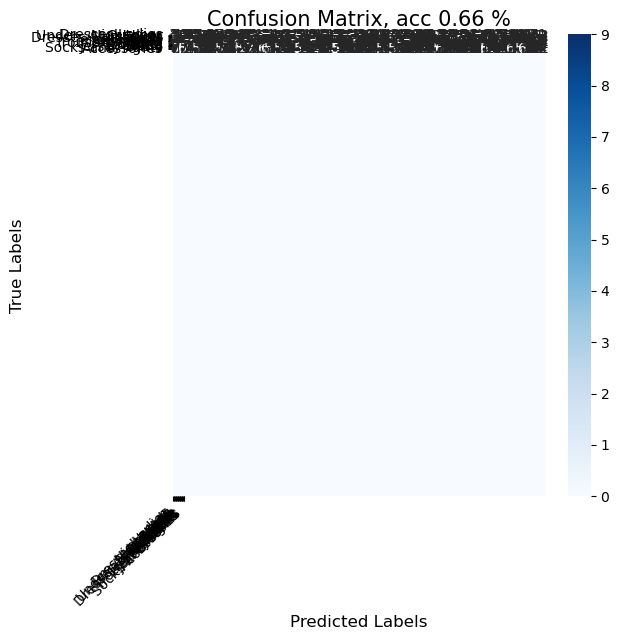

Accuracy of baseline is 0.66 %


In [12]:
update()
BALANCED = False
def baseline(dataloaders, add):
    clip = {'m':model, 'p':processor}
    ft = training.FinetuneCLIP(dataloaders, clip)
    ft.conf = {'epochs': 400, 'balanced':BALANCED}
    ft.tt['soft'], ft.tt['LoRA'], ft.tt['desc'] = 0, 0, 1 #baseline
    ft.initialize({'add':add}, False)
    all_predictions, all_labels, acc = ft.eval(False)
    utils.confussion_matrix(all_labels, all_predictions, list(dataloaders['test'].dataset.classes),F1=False)
    return acc

acc = baseline(dataloaders, '')
print(f"Accuracy of baseline is {acc:.2f} %")